In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd

from numpy import genfromtxt
from scipy import stats

In [75]:
# this is z-score that value minus mean divided by standard deviation
# http://duramecho.com/Misc/WhyMinusOneInSd.html
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1]
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

In [76]:
def read_data(file_name):
    df = pd.read_csv(file_name, sep=',', header=None)
    return df

def merge_column(df):
    new_df = pd.DataFrame()
    for i in range(df.shape[1]/2):
        new_df[i] = df[i] * df[i+1]
    return new_df

In [77]:
df = read_data('poker-hand-training-true.data')
df_test = read_data('poker-hand-testing.data')
print(df.tail())
print(df_test.tail())
df = df[df[10] != 0]
df_test = df_test[df_test[10] != 0]
# df[df[10].equals(0)].value_counts().sort_index().plot('bar')
# df[10].value_counts().sort_index().plot('bar')

       0   1   2   3   4   5   6   7   8   9   10
25005   3   9   2   6   4  11   4  12   2   4   0
25006   4   1   4  10   3  13   3   4   1  10   1
25007   2   1   2  10   4   4   4   1   4  13   1
25008   2  12   4   3   1  10   1  12   4   9   1
25009   1   7   3  11   3   3   4   8   3   7   1
        0   1   2   3   4   5   6   7   8   9   10
999995   3   1   1  12   2   9   4   9   2   6   1
999996   3   3   4   5   2   7   1   4   4   3   1
999997   1  11   4   7   3   9   1  13   2   7   1
999998   3  11   1   8   1   1   3  13   2   8   1
999999   2   5   2   9   4   9   2   3   3   3   2


In [78]:
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1:].values
print(stats.describe(features).variance)
print(features.shape, labels.shape)

features_test = df_test.iloc[:, :-1].values
labels_test = df_test.iloc[:, -1:].values

[  1.23984746  14.09081675   1.25621937  14.21451941   1.26434212
  14.04456486   1.23643468  14.09136767   1.24684169  13.99689843]
(12517, 10) (12517, 1)


In [79]:
features = feature_normalize(features)
print(stats.describe(features).variance)

features_test = feature_normalize(features_test)
print(stats.describe(features_test).variance)

[ 1.0000799  1.0000799  1.0000799  1.0000799  1.0000799  1.0000799
  1.0000799  1.0000799  1.0000799  1.0000799]
[ 1.000002  1.000002  1.000002  1.000002  1.000002  1.000002  1.000002
  1.000002  1.000002  1.000002]


In [80]:
train_x = features
train_y = labels
test_x = features_test
test_y = labels_test

feature_count = train_x.shape[1]
label_count = train_y.shape[1]
print(feature_count, label_count)

10 1


In [81]:
training_epochs = 5000
learning_rate = 0.1
cost_history = np.empty(shape=[1],dtype=float)
nb_classes = 10

# x는 float32 로 할 필요가 있나? normalized 되었기때문에 float32 써야함
X = tf.placeholder(tf.float32,[None,feature_count])
Y = tf.placeholder(tf.int32,[None,label_count])
Y_one_hot = tf.one_hot(Y, nb_classes)  # one hot
print("one_hot", Y_one_hot)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
print("reshape", Y_one_hot)

one_hot Tensor("one_hot_4:0", shape=(?, 1, 10), dtype=float32)
reshape Tensor("Reshape_16:0", shape=(?, 10), dtype=float32)


In [82]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.1))

def model(X, p_keep_input, p_keep_hidden): # this network is the same as the previous one except with an extra hidden layer + dropout
    s_1 = feature_count + 4
    s_2 = feature_count + 4
    
    w_h = init_weights([feature_count, s_1])
    w_h2 = init_weights([s_1, s_2])
    w_o = init_weights([s_2, nb_classes])
    
    b = tf.Variable(tf.random_normal([s_1]))
    b2 = tf.Variable(tf.random_normal([s_2]))
    b_o = tf.Variable(tf.random_normal([nb_classes]))
    
    X = tf.nn.dropout(X, p_keep_input)
    h = tf.nn.relu(tf.matmul(X, w_h) + b)
    h = tf.nn.dropout(h, p_keep_hidden)
    h2 = tf.nn.relu(tf.matmul(h, w_h2) + b2)
    h2 = tf.nn.dropout(h2, p_keep_hidden)
    
    
    return tf.matmul(h2, w_o) + b_o

In [83]:
p_keep_input = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")

h0 = model(X, p_keep_input, p_keep_hidden)

In [84]:
# Cross entropy cost/loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=h0, labels=Y_one_hot))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [85]:
prediction = tf.argmax(h0, 1)
correct_prediction = tf.equal(prediction, tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [86]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
print(X.shape, Y.shape)
training_dropout_i = 0.8
training_dropout_h = 0.7
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for step in range(training_epochs + 1):
        sess.run(optimizer, feed_dict={X: train_x, Y: train_y, p_keep_input: training_dropout_i, p_keep_hidden: training_dropout_h})
        loss, acc = sess.run([cost, accuracy], feed_dict={
                                 X: train_x, Y: train_y, p_keep_input: training_dropout_i, p_keep_hidden: training_dropout_h})
        cost_history = np.append(cost_history, acc)
        if step % 1000 == 0:
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(
                step, loss, acc))
            
    # Test model and check accuracy
    pre = tf.argmax(h0, 1)
    test_yy = np.transpose(test_y.ravel())
    print(test_yy.shape)
    correct_prediction = tf.equal(pre, test_yy)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Test Accuracy:', sess.run(accuracy, feed_dict={X: test_x, 
                                                         p_keep_input: 1.0,
                                                         p_keep_hidden: 1.0}))

(12517, 10) (12517, 1)
(498791, 10) (498791, 1)
(?, 10) (?, 1)
Step:     0	Loss: 3.621	Acc: 0.43%
Step:  1000	Loss: 0.573	Acc: 84.68%
Step:  2000	Loss: 0.571	Acc: 84.69%
Step:  3000	Loss: 0.571	Acc: 84.61%
Step:  4000	Loss: 0.570	Acc: 84.70%
Step:  5000	Loss: 0.571	Acc: 84.71%
(498791,)
Test Accuracy: 0.847044


(5002,)


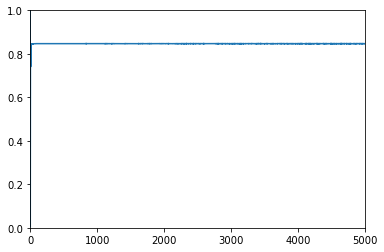

In [87]:
print(cost_history.shape)
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,1])
plt.show()

In [88]:
sess.close()